# Homework 9 

Gabriel Mastromatteo 1006749761 

## Question 1 

#### Starting at Subquestion 2 

#### Load and Prepare Dataset

In [114]:
import numpy as np
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv("Macro_data_can.csv")
data = df.dropna()

# Convert the first three columns to numeric (in case they aren't already)
# You can also use errors='coerce' to turn any non-numeric entries into NaN
data.iloc[:, 1:4] = data.iloc[:, 1:4].apply(pd.to_numeric, errors='coerce')

# Convert to a NumPy array of type float
y = data.iloc[:, 1:4].astype(float).values
print("Data shape:", y.shape)
print("Data types:", y.dtype)

Data shape: (335, 3)
Data types: float64


#### Marginal for Variable 1 (using a Gamma model)

In [115]:
with pm.Model() as gamma_model:
    # Prior for the shape parameter
    alpha0 = pm.HalfNormal('alpha0', sigma=10)
    # Gamma likelihood with beta fixed at 1 (scale=1)
    y0 = pm.Gamma('y0', alpha=alpha0, beta=1, observed=y[:, 0])
    trace_gamma = pm.sample(return_inferencedata=True)
    
# Extract the posterior mean of alpha0 to use for the CDF transformation
alpha0_mean = trace_gamma.posterior['alpha0'].mean().values
print("Posterior mean for alpha0 (Gamma):", alpha0_mean)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Posterior mean for alpha0 (Gamma): 117.91945611753083


####  Marginal for Variable 2 

In [116]:
with pm.Model() as exp_model:
    # Prior for the rate parameter (lambda)
    lam1 = pm.HalfNormal('lam1', sigma=10)
    y1 = pm.Exponential('y1', lam=lam1, observed=y[:, 1])
    trace_exp = pm.sample(return_inferencedata=True)
    
# Extract the posterior mean of lam1 for the CDF transformation
lam1_mean = trace_exp.posterior['lam1'].mean().values
print("Posterior mean for lam1 (Exponential):", lam1_mean)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Posterior mean for lam1 (Exponential): 0.0005694672696971351


####  Marginal for Variable 3 

In [117]:
with pm.Model() as chi2_model:
    # Prior for the degrees of freedom (nu)
    nu2 = pm.HalfNormal('nu2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=nu2, observed=y[:, 2])
    trace_chi2 = pm.sample(return_inferencedata=True)
    
# Extract the posterior mean of nu2 for the CDF transformation
nu2_mean = trace_chi2.posterior['nu2'].mean().values
print("Posterior mean for nu2 (ChiSquared):", nu2_mean)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Posterior mean for nu2 (ChiSquared): 7.997828788805009


#### Transforming Data to the Uniform Scale

In [118]:
# Compute the CDF for each observation using the posterior means
u0 = gamma.cdf(y[:, 0], a=alpha0_mean, scale=1.0)
u1 = expon.cdf(y[:, 1], scale=1.0/lam1_mean)
u2 = chi2.cdf(y[:, 2], df=nu2_mean)

# Clip values to avoid exactly 0 or 1 (which would produce -inf or inf)
eps = 1e-6
u0 = np.clip(u0, eps, 1 - eps)
u1 = np.clip(u1, eps, 1 - eps)
u2 = np.clip(u2, eps, 1 - eps)

# Convert the [0,1] values to standard normal variates via the inverse CDF (ppf)
z0 = norm.ppf(u0)
z1 = norm.ppf(u1)
z2 = norm.ppf(u2)

# Combine the transformed data into one array
z_data = np.column_stack([z0, z1, z2])
print("Transformed data shape (z_data):", z_data.shape)
print("Any NaNs in transformed data?", np.isnan(z_data).any())

Transformed data shape (z_data): (335, 3)
Any NaNs in transformed data? False


#### Fitting the Gaussian Copula

In [119]:
with pm.Model() as corr_model:
    # Define a prior for the Cholesky factor of the covariance matrix using an LKJ prior.
    L, R, stds = pm.LKJCholeskyCov(
        "R",
        n=3,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=3),
        compute_corr=True
    )
    
    # Model the pseudo-observations as coming from a multivariate normal
    pm.MvNormal(
        "obs",
        mu=np.zeros(3),
        chol=L,
        observed=z_data
    )
    
    # Sample from the posterior to estimate the correlation structure
    trace_corr = pm.sample(return_inferencedata=True)
    
# Summarize the inferred correlation matrix
print(az.summary(trace_corr, var_names=["R"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]  1.743  0.066   1.628    1.874      0.001    0.001    4334.0    3397.0   
R[1]  0.169  0.019   0.134    0.204      0.000    0.000    3734.0    3087.0   
R[2]  0.330  0.013   0.307    0.355      0.000    0.000    3742.0    3050.0   
R[3] -0.136  0.016  -0.165   -0.105      0.000    0.000    3877.0    3423.0   
R[4] -0.083  0.015  -0.110   -0.055      0.000    0.000    4232.0    3093.0   
R[5]  0.269  0.010   0.250    0.289      0.000    0.000    4429.0    2769.0   

      r_hat  
R[0]    1.0  
R[1]    1.0  
R[2]    1.0  
R[3]    1.0  
R[4]    1.0  
R[5]    1.0  


#### Posterior Summary

Available variables in the posterior: ['R', 'R_corr', 'R_stds']
Posterior Summary for Correlation Matrix R_corr:
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
R_corr[0, 0]  1.000  0.000   1.000    1.000      0.000      NaN    4000.0   
R_corr[0, 1]  0.454  0.042   0.376    0.536      0.001    0.001    3762.0   
R_corr[0, 2] -0.434  0.044  -0.510   -0.348      0.001    0.001    3865.0   
R_corr[1, 0]  0.454  0.042   0.376    0.536      0.001    0.001    3762.0   
R_corr[1, 1]  1.000  0.000   1.000    1.000      0.000    0.000    3496.0   
R_corr[1, 2] -0.433  0.044  -0.515   -0.352      0.001    0.001    4322.0   
R_corr[2, 0] -0.434  0.044  -0.510   -0.348      0.001    0.001    3865.0   
R_corr[2, 1] -0.433  0.044  -0.515   -0.352      0.001    0.001    4322.0   
R_corr[2, 2]  1.000  0.000   1.000    1.000      0.000    0.000    3718.0   

              ess_tail  r_hat  
R_corr[0, 0]    4000.0    NaN  
R_corr[0, 1]    3155.0    1.0  
R_corr[0, 2]    3110

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


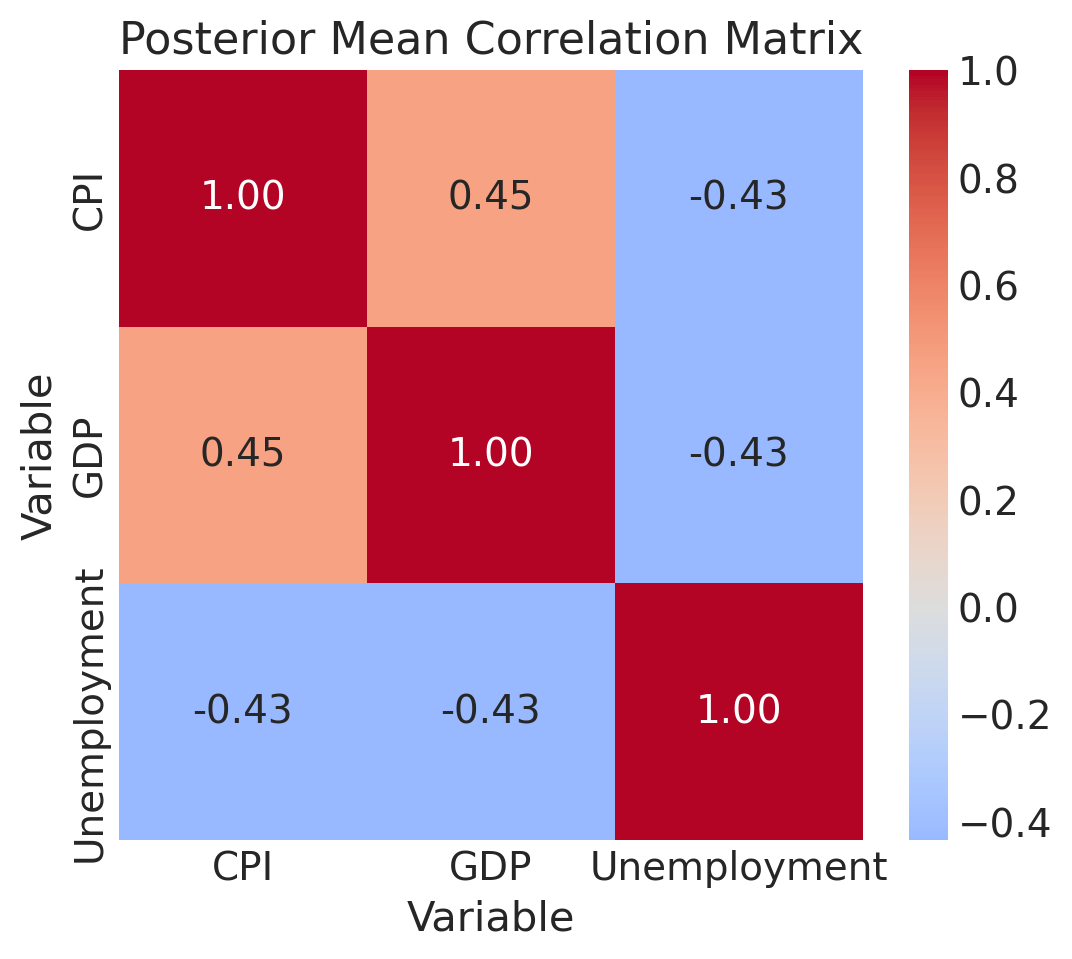

In [121]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume that 'data' has already been loaded as in previous steps:
# For example:
# data = pd.read_csv("Macro_data_can.csv")
# and we used the first three columns for the analysis.
var_names = data.columns[1:4].tolist()

# Check available variables in the posterior (optional)
print("Available variables in the posterior:", list(trace_corr.posterior.data_vars))

# Extract and summarize the correlation matrix using the key "R_corr"
summary_corr = az.summary(trace_corr, var_names=["R_corr"])
print("Posterior Summary for Correlation Matrix R_corr:")
print(summary_corr)

# Extract the correlation samples. 
# This assumes the shape is (chains, draws, 3, 3)
R_samples = trace_corr.posterior["R_corr"].values  

# Compute the posterior mean correlation matrix by averaging over chains and draws.
R_mean = np.mean(R_samples, axis=(0, 1))
print("\nPosterior Mean Correlation Matrix:")
print(R_mean)

# Visualize the posterior mean correlation matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(R_mean, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            xticklabels=var_names, yticklabels=var_names)
plt.title("Posterior Mean Correlation Matrix")
plt.xlabel("Variable")
plt.ylabel("Variable")
plt.show()

## 3) What Is a Copula, and How Do the Two Versions of Code Implement It?

### What Is a Copula?

A **copula** is a function that links multivariate joint distributions to their one-dimensional marginal distributions. In simple terms, it allows us to model the dependence (or correlation) between variables separately from the behavior of each individual variable.

**Key Concepts:**
- **Marginal Distributions:** Describe the behavior of each variable on its own.
- **Dependence Structure:** Captures how the variables relate to each other.
- **Sklar’s Theorem:** States that any multivariate joint distribution can be decomposed into its marginals and a copula that “couples” them together.

### How the Code Implements a Copula

There are two approaches demonstrated in the code: a **single-pass** approach and a **two-pass** approach.

### Single-Pass Approach

- **Simultaneous Modeling:**  
  In the single-pass model, the marginals and the dependence structure are estimated **together** within one joint model.
  
- **Marginal Specification:**  
  Each variable is modeled using a suitable distribution (e.g., Gamma, Exponential, ChiSquared).  
  Within the model, each marginal observation is transformed into a standard normal space using an inverse CDF transformation.

- **Dependence Modeling:**  
  A multivariate normal (MVN) likelihood is specified on the transformed variables.  
  An LKJ prior is used to infer the correlation matrix, which represents the copula capturing the dependence between the variables.

- **Pros & Cons:**  
  - *Pros:* Fully Bayesian—uncertainty in the marginal parameters propagates to the dependence estimation.
  - *Cons:* Can be computationally challenging and may lead to sampling issues (warnings, divergences) in complex models.

### Two-Pass Approach

- **Step 1: Marginal Estimation**  
  Each marginal distribution is estimated **independently** (e.g., Gamma for column 0, Exponential for column 1, and ChiSquared for column 2).  
  The posterior estimates (or MAP values) from these models are used to compute the CDF for each observed value, transforming the data into the [0, 1] interval.

- **Step 2: Dependence Estimation (Copula Fitting)**  
  The [0, 1]-scaled data are then transformed into standard normal variates using the inverse CDF (i.e., `norm.ppf`).  
  These transformed values are assumed to come from a multivariate normal distribution whose correlation matrix is estimated using an LKJ prior.  
  This step captures the dependence structure among the variables—the copula.

- **Advantages:**  
  - *Simpler Model:* Breaking the problem into two parts often simplifies sampling and debugging.
  - *Efficiency:* Avoids some of the computational challenges of a single large model.

- **Limitations:**  
  - The two-pass approach might not fully propagate the uncertainty from the marginal estimates into the dependence structure unless additional hierarchical modeling is implemented.

### Summary

Both approaches aim to decompose the joint modeling problem:
- The **single-pass approach** does it all at once, ensuring full propagation of uncertainty but at the cost of complexity.
- The **two-pass approach** decouples marginal estimation from dependence modeling, which can simplify the computation but may lose some uncertainty propagation.

Understanding these two implementations helps in selecting the right method for your data analysis, balancing between model complexity and computational efficiency.


## 4) Using Copulas for Arbitrary Multivariate GLM Regressions

When you have multiple outcomes that follow different distributions, you can model each outcome separately using a Generalized Linear Model (GLM) while using a copula to capture the dependence structure among them. This approach decouples the modeling of each outcome’s marginal distribution from the modeling of the joint dependence.

---

### How It Works

#### 1. Model Each Outcome with a GLM
For each outcome, choose a likelihood that fits its distribution. For example, suppose we have three outcomes:
- **Outcome 1:** Gamma-distributed (e.g., positive, skewed data)
- **Outcome 2:** Exponential-distributed (e.g., waiting times)
- **Outcome 3:** Chi-Squared-distributed (e.g., variance estimates)

You would specify a GLM for each outcome. For example, for a Gamma-distributed outcome with predictors `X`:

```python
with pm.Model() as gamma_glm:
    # Regression coefficients for predictors in X
    beta = pm.Normal('beta', 0, 1, shape=X.shape[1])
    # A positive shape parameter
    alpha = pm.HalfNormal('alpha', sigma=10)
    # Linear predictor (using an exponential link for positivity)
    mu = pm.math.exp(pm.math.dot(X, beta))
    # Gamma likelihood (using mu to define the rate)
    y_obs = pm.Gamma('y_obs', alpha=alpha, beta=mu, observed=y1)
    trace_gamma_glm = pm.sample(return_inferencedata=True)
```

## Question 2 

####  Data Loading and Preparation

In [125]:
# Load the CSV data (adjust the path if needed)
data = pd.read_csv("Macro_data_can.csv")

# Quick look at the first few rows
data.head()

,Index,CPI,GDP,Unemployment,Target.Rate
0,1997-02-01,90.1,1211.631,9.5,3.0
1,1997-03-01,90.2,1211.507,9.3,3.0
2,1997-04-01,90.2,1219.735,9.4,3.0
3,1997-05-01,90.2,1224.088,9.4,3.0
4,1997-06-01,90.3,1226.403,9.1,3.0


In [127]:
# Optionally, take a subset of rows for faster computation (e.g., first 200 rows)
data_subset = data.iloc[:200].copy()

# Define your response and predictor variables.
# Adjust the names below to match your CSV's column names.
response_var = "GDP"           # Example response variable
predictor_vars = ["Target.Rate", "CPI", "Unemployment"]  # Example predictors

# Extract the response and predictors as NumPy arrays
y = data_subset[response_var].values
X = data_subset[predictor_vars].values

# Number of predictors (used in model specification)
n_predictors = X.shape[1]

#### Spike-and-Slab 

In [128]:
with pm.Model() as spike_slab_model:
    # Prior for the inclusion probability (you can fix it or put a Beta prior)
    p = pm.Beta("p", alpha=1, beta=1)
    
    # Latent binary indicators for each predictor (1 = included, 0 = near-zero effect)
    gamma = pm.Bernoulli("gamma", p=p, shape=n_predictors)
    
    # Slab: a weakly regularizing (diffuse) prior for coefficients if included
    slab_sd = 10
    beta_slab = pm.Normal("beta_slab", mu=0, sigma=slab_sd, shape=n_predictors)
    
    # Spike: a prior that forces coefficients to be near zero when not included
    spike_sd = 0.1
    beta_spike = pm.Normal("beta_spike", mu=0, sigma=spike_sd, shape=n_predictors)
    
    # Combined coefficient: if gamma[i]==1 use beta_slab; otherwise use beta_spike (≈0)
    beta = pm.Deterministic("beta", gamma * beta_slab + (1 - gamma) * beta_spike)
    
    # Prior for the intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood: standard linear regression model
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Sample from the posterior
    trace_spike = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=123)
    
# Print a summary for key parameters
print(az.summary(trace_spike, var_names=["intercept", "beta", "p", "gamma"]))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, beta_slab, beta_spike, intercept, sigma]
>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


             mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  28.829  10.089  10.697   48.547      0.150    0.128    4507.0   
beta[0]     3.478   0.621   2.347    4.699      0.008    0.006    6784.0   
beta[1]    16.504   0.076  16.366   16.648      0.001    0.001    5514.0   
beta[2]   -30.770   0.928 -32.493  -29.052      0.011    0.009    7317.0   
p           0.801   0.163   0.503    1.000      0.002    0.002    7836.0   
gamma[0]    1.000   0.000   1.000    1.000      0.000      NaN    8000.0   
gamma[1]    1.000   0.000   1.000    1.000      0.000      NaN    8000.0   
gamma[2]    1.000   0.000   1.000    1.000      0.000      NaN    8000.0   

           ess_tail  r_hat  
intercept    4861.0    1.0  
beta[0]      6199.0    1.0  
beta[1]      5035.0    1.0  
beta[2]      5979.0    1.0  
p            3270.0    1.0  
gamma[0]     8000.0    NaN  
gamma[1]     8000.0    NaN  
gamma[2]     8000.0    NaN  


/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


####  Diffuse Prior Bayesian Regression

In [130]:
with pm.Model() as diffuse_model:
    # Diffuse (weakly informative) priors for coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=n_predictors)
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Sample from the posterior
    trace_diffuse = pm.sample(2000, tune=1000, target_accept=0.95, random_seed=123)
    
# Print a summary for the diffuse model
print(az.summary(trace_diffuse, var_names=["intercept", "beta"]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  28.579  9.675   9.874   46.063      0.155    0.113    3879.0   
beta[0]     3.478  0.618   2.306    4.639      0.009    0.007    4897.0   
beta[1]    16.505  0.074  16.370   16.647      0.001    0.001    4200.0   
beta[2]   -30.751  0.912 -32.399  -28.983      0.012    0.010    5328.0   

           ess_tail  r_hat  
intercept    4640.0    1.0  
beta[0]      4561.0    1.0  
beta[1]      4615.0    1.0  
beta[2]      5095.0    1.0  


#### Compare Model Results

In [131]:
# Extract posterior inclusion probabilities (mean of gamma) from the spike-and-slab model
gamma_means = trace_spike.posterior["gamma"].mean(dim=["chain", "draw"]).values

# Extract posterior mean estimates for beta from the spike-and-slab model
beta_spike_means = trace_spike.posterior["beta"].mean(dim=["chain", "draw"]).values

# Extract posterior mean estimates for beta from the diffuse model
beta_diffuse_means = trace_diffuse.posterior["beta"].mean(dim=["chain", "draw"]).values

# Create a DataFrame to compare the two models for each predictor
comparison_df = pd.DataFrame({
    "Predictor": predictor_vars,
    "Spike_Slab_Inclusion_Prob": gamma_means,
    "Spike_Slab_Coeff_Mean": beta_spike_means,
    "Diffuse_Coeff_Mean": beta_diffuse_means
})

print(comparison_df)

      Predictor  Spike_Slab_Inclusion_Prob  Spike_Slab_Coeff_Mean  \
0   Target.Rate                        1.0               3.477742   
1           CPI                        1.0              16.504440   
2  Unemployment                        1.0             -30.769598   

   Diffuse_Coeff_Mean  
0            3.478487  
1           16.505393  
2          -30.750790  


#### Diagnostic Plots

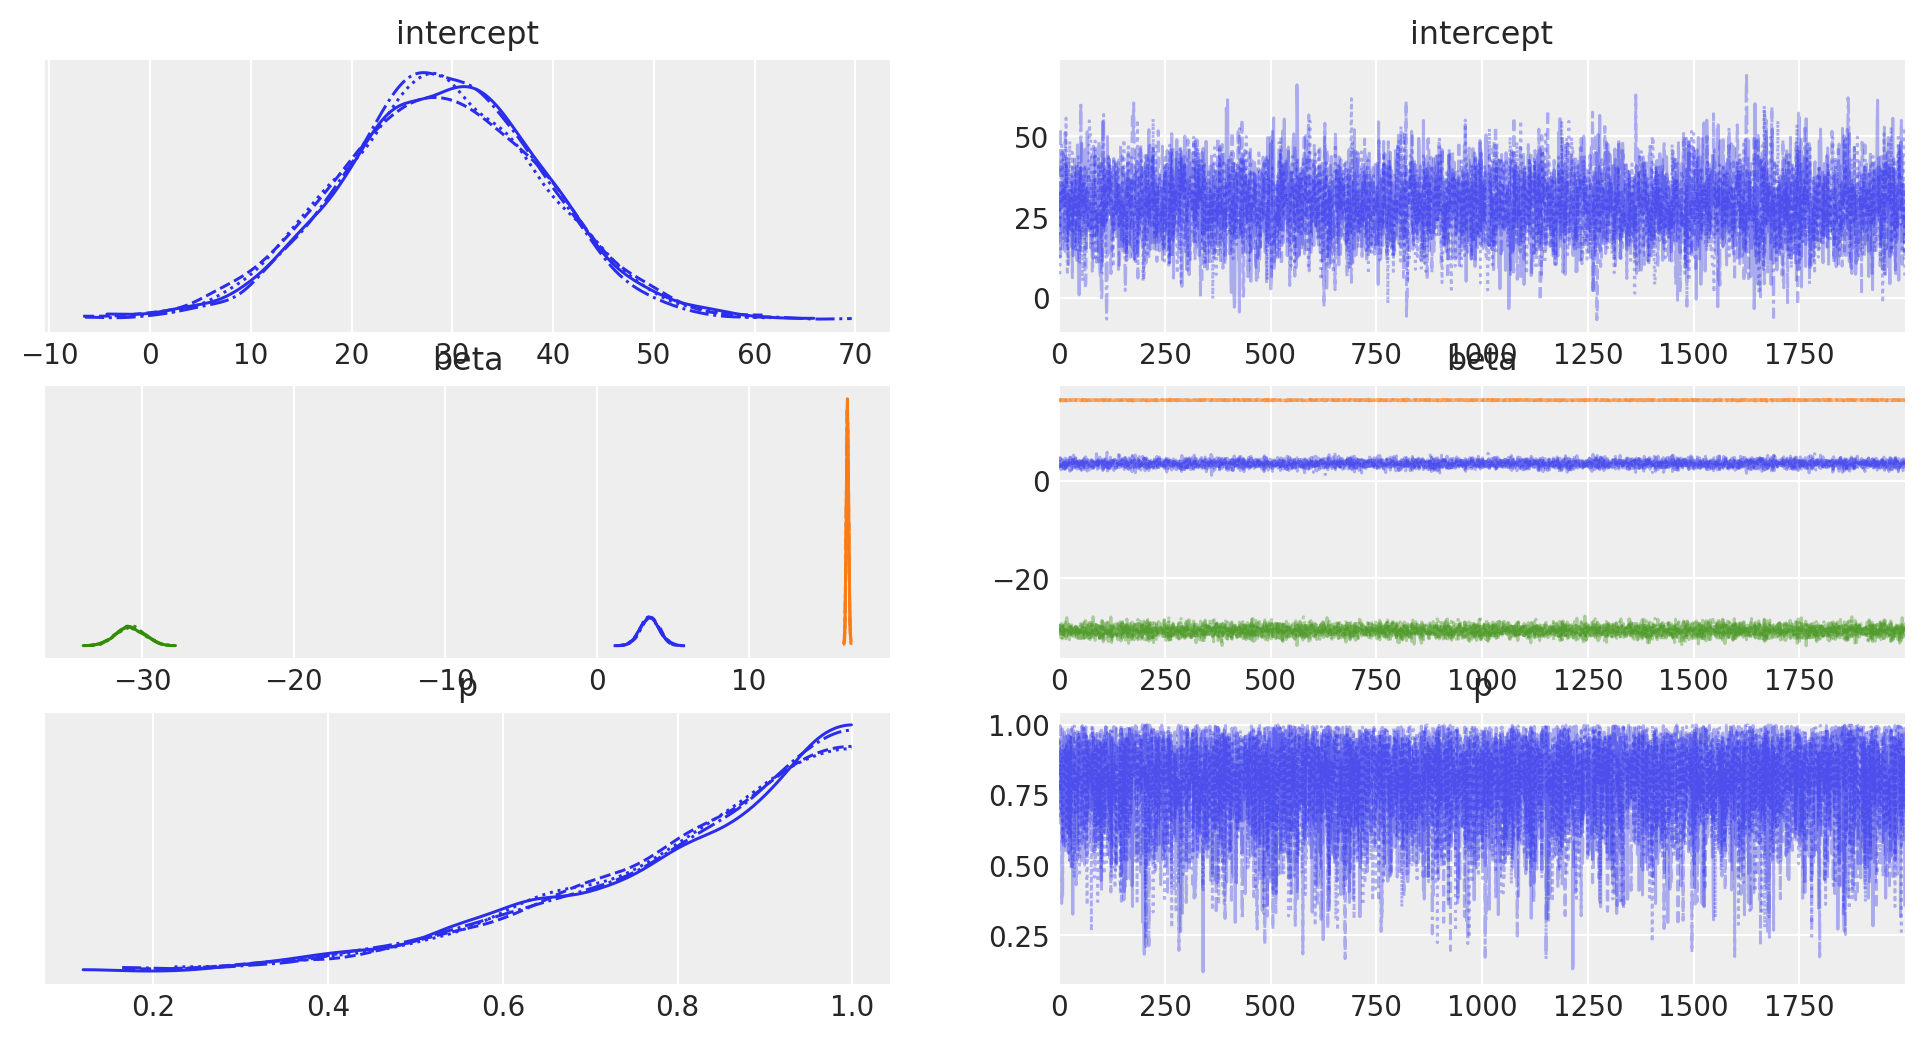

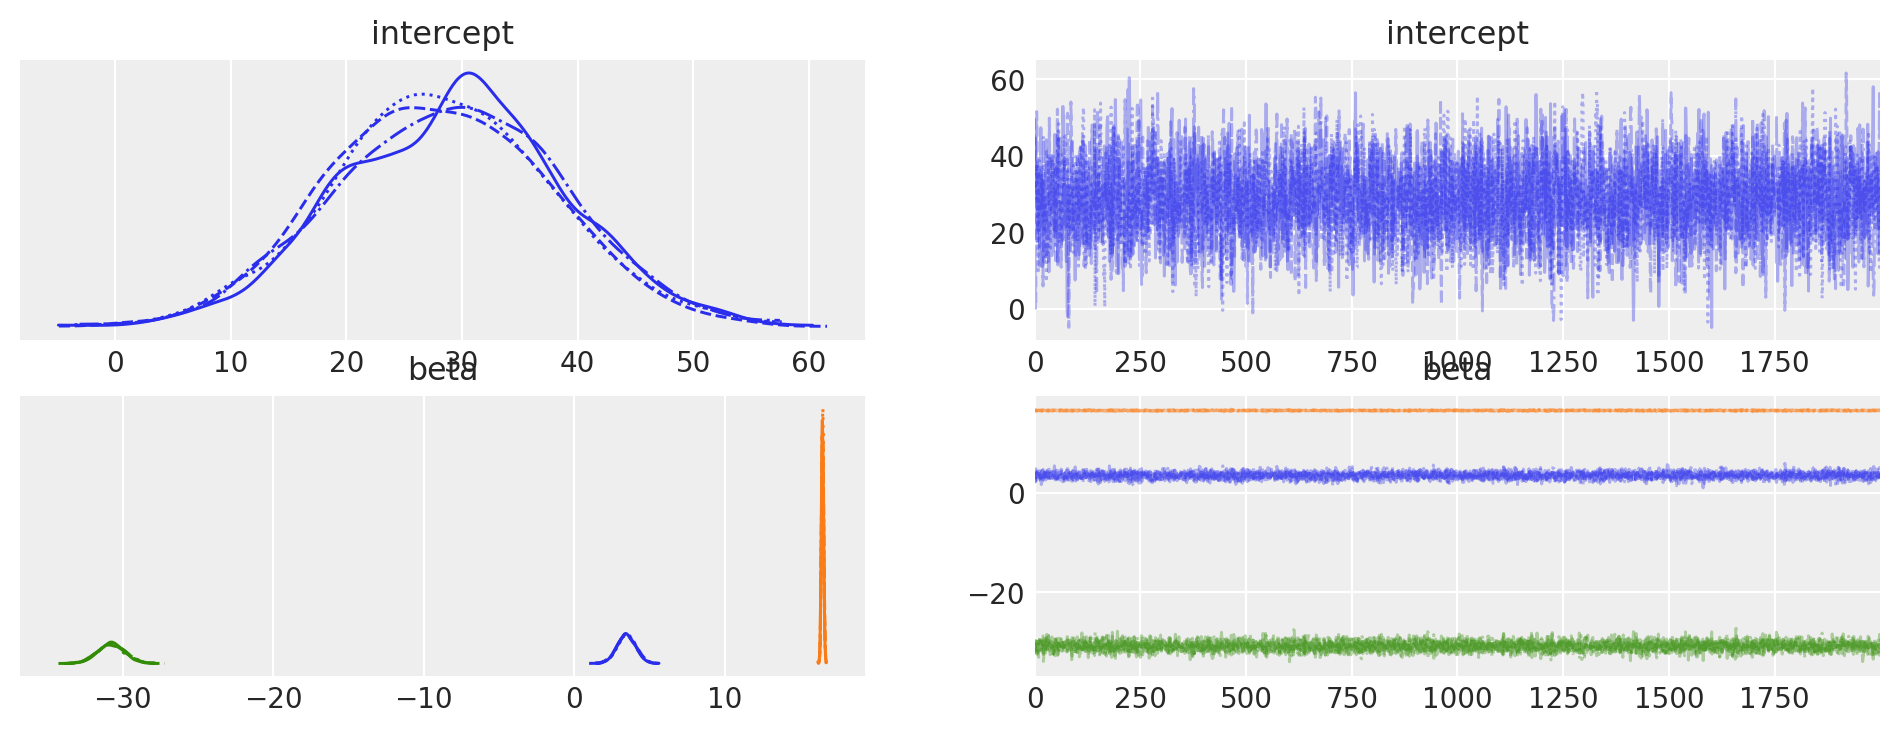

In [134]:
# Trace plots for the spike-and-slab model (intercept, coefficients, inclusion probability)
az.plot_trace(trace_spike, var_names=["intercept", "beta", "p"])
plt.show()

# Trace plots for the diffuse model (intercept and coefficients)
az.plot_trace(trace_diffuse, var_names=["intercept", "beta"])
plt.show()


### Question 3 

### Horseshoe Prior for Variable Selection

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, lam, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


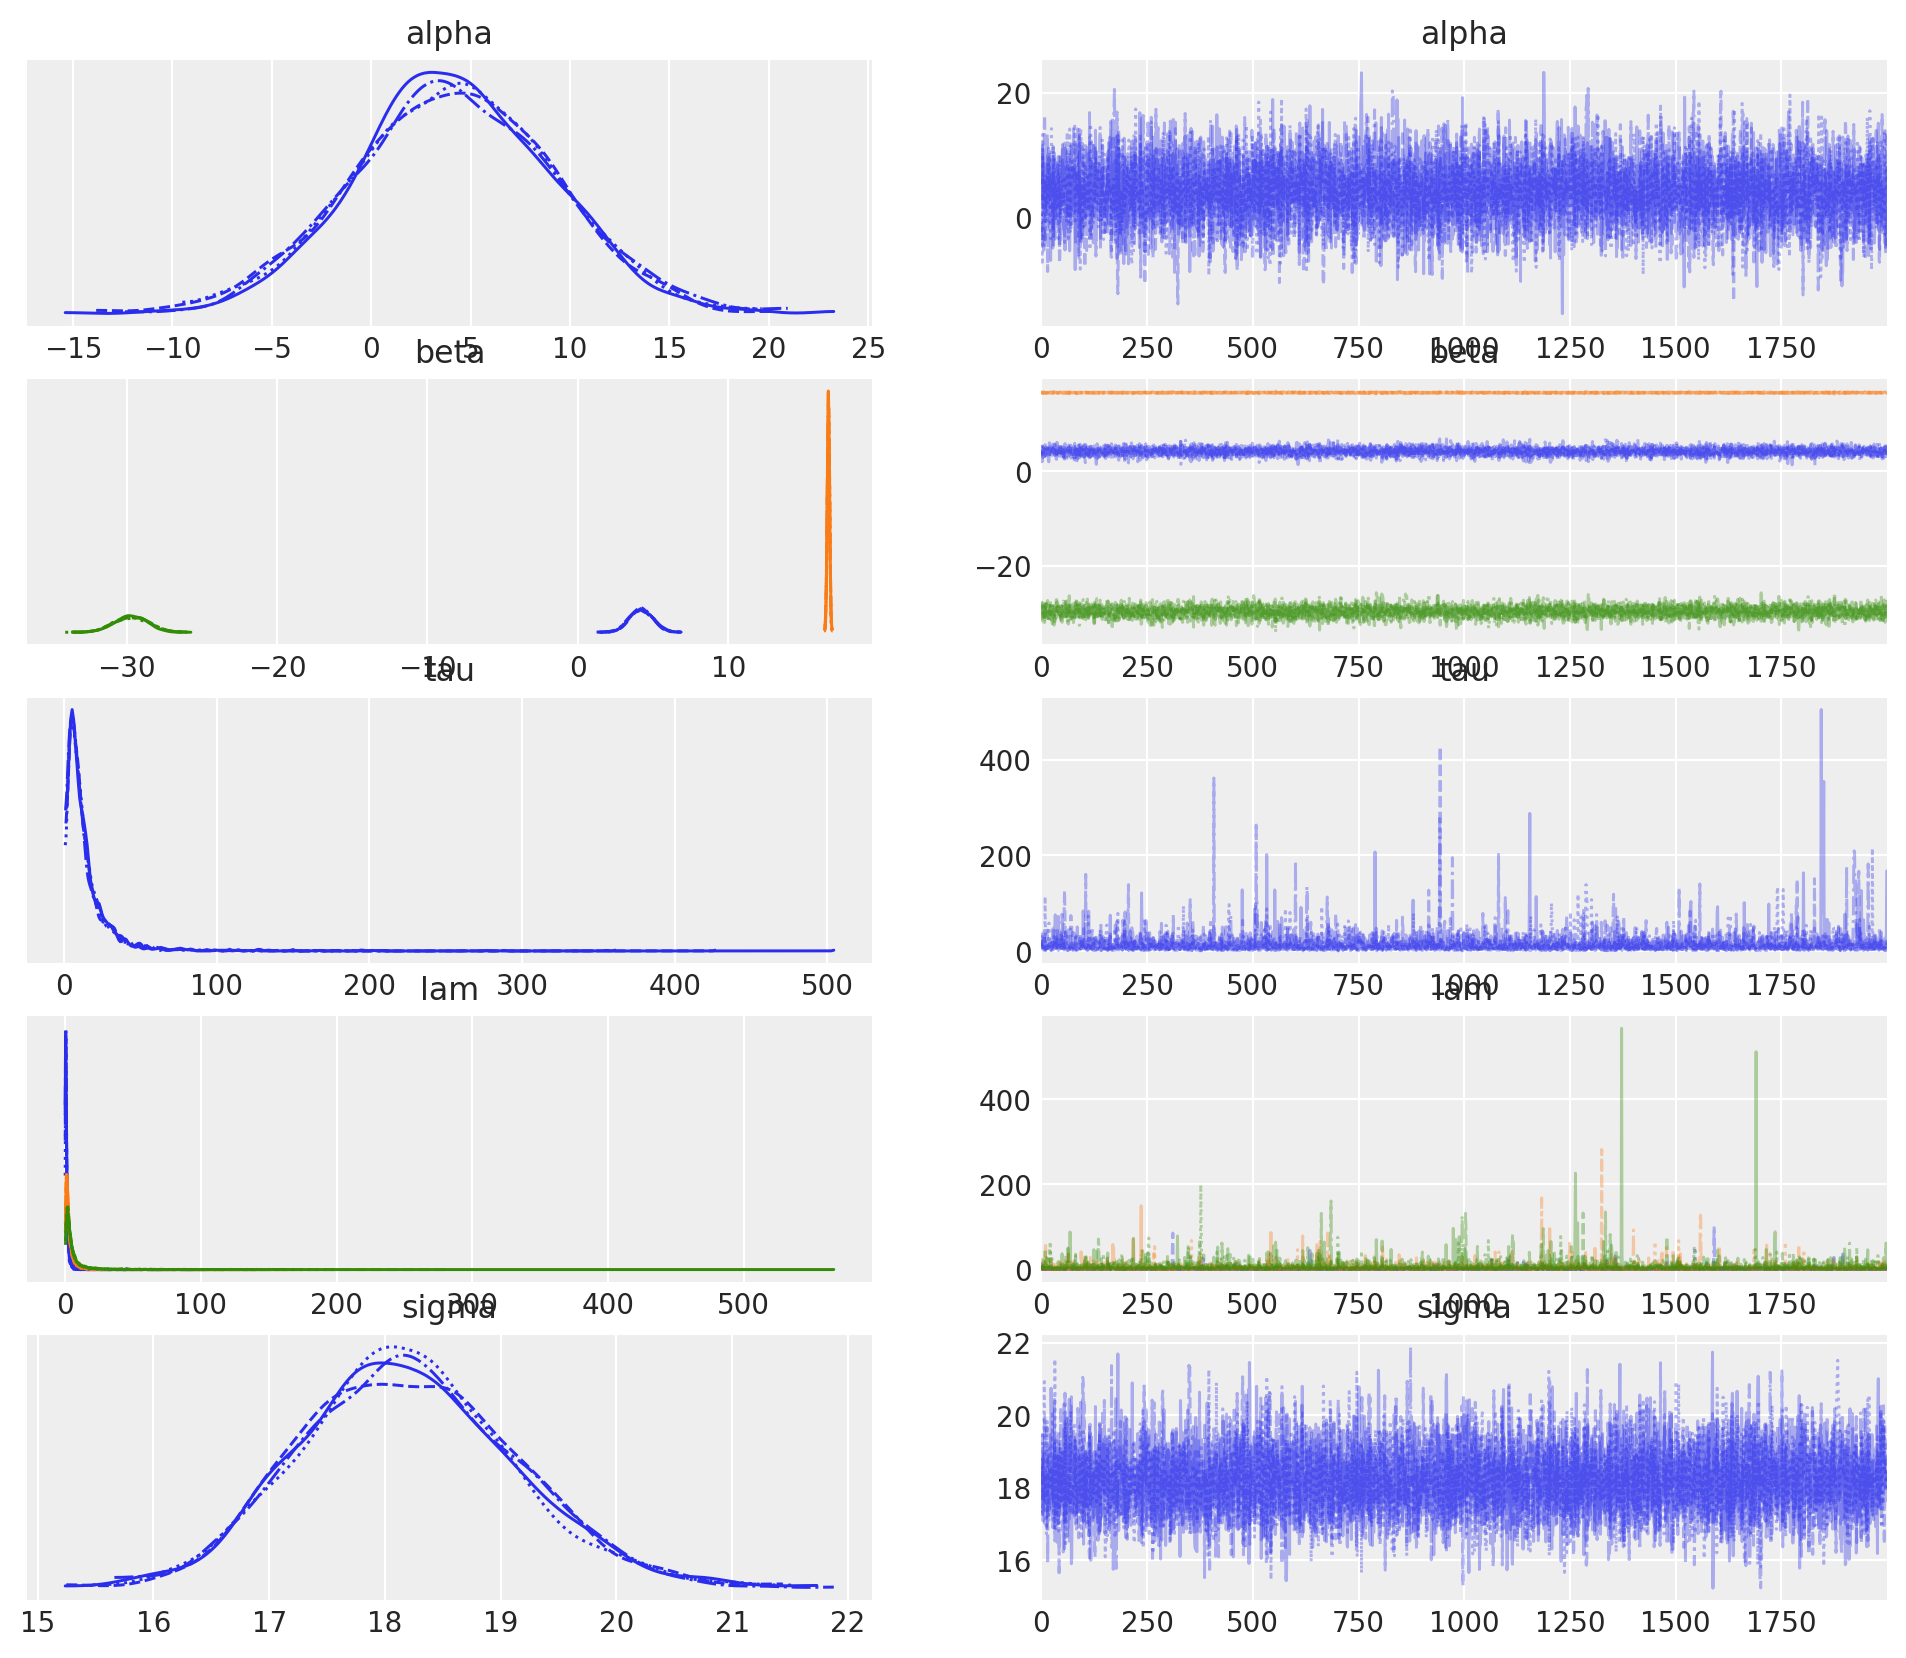

In [136]:
n, k = X.shape

with pm.Model() as model_horseshoe:
    # Intercept
    alpha = pm.Normal("alpha", mu=0, sigma=5)

    # Global shrinkage parameter
    tau = pm.HalfCauchy("tau", beta=1)

    # Local shrinkage parameters for each predictor
    lam = pm.HalfCauchy("lam", beta=1, shape=k)

    # Coefficients with Horseshoe prior
    # The product tau * lam implements the global-local shrinkage
    beta = pm.Normal("beta", mu=0, sigma=tau * lam, shape=k)

    # Noise standard deviation
    sigma = pm.HalfCauchy("sigma", beta=1)

    # Expected value
    mu = alpha + pm.math.dot(X, beta)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # MCMC sampling
    trace_horseshoe = pm.sample(
        draws=2000, tune=1000, target_accept=0.9, random_seed=42
    )

# Summaries and diagnostics
az.summary(trace_horseshoe, var_names=["alpha", "beta", "tau", "lam", "sigma"])
az.plot_trace(trace_horseshoe, var_names=["alpha", "beta", "tau", "lam", "sigma"]);

### Spike-and-Slab Prior

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, slab_sd, beta, sigma]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


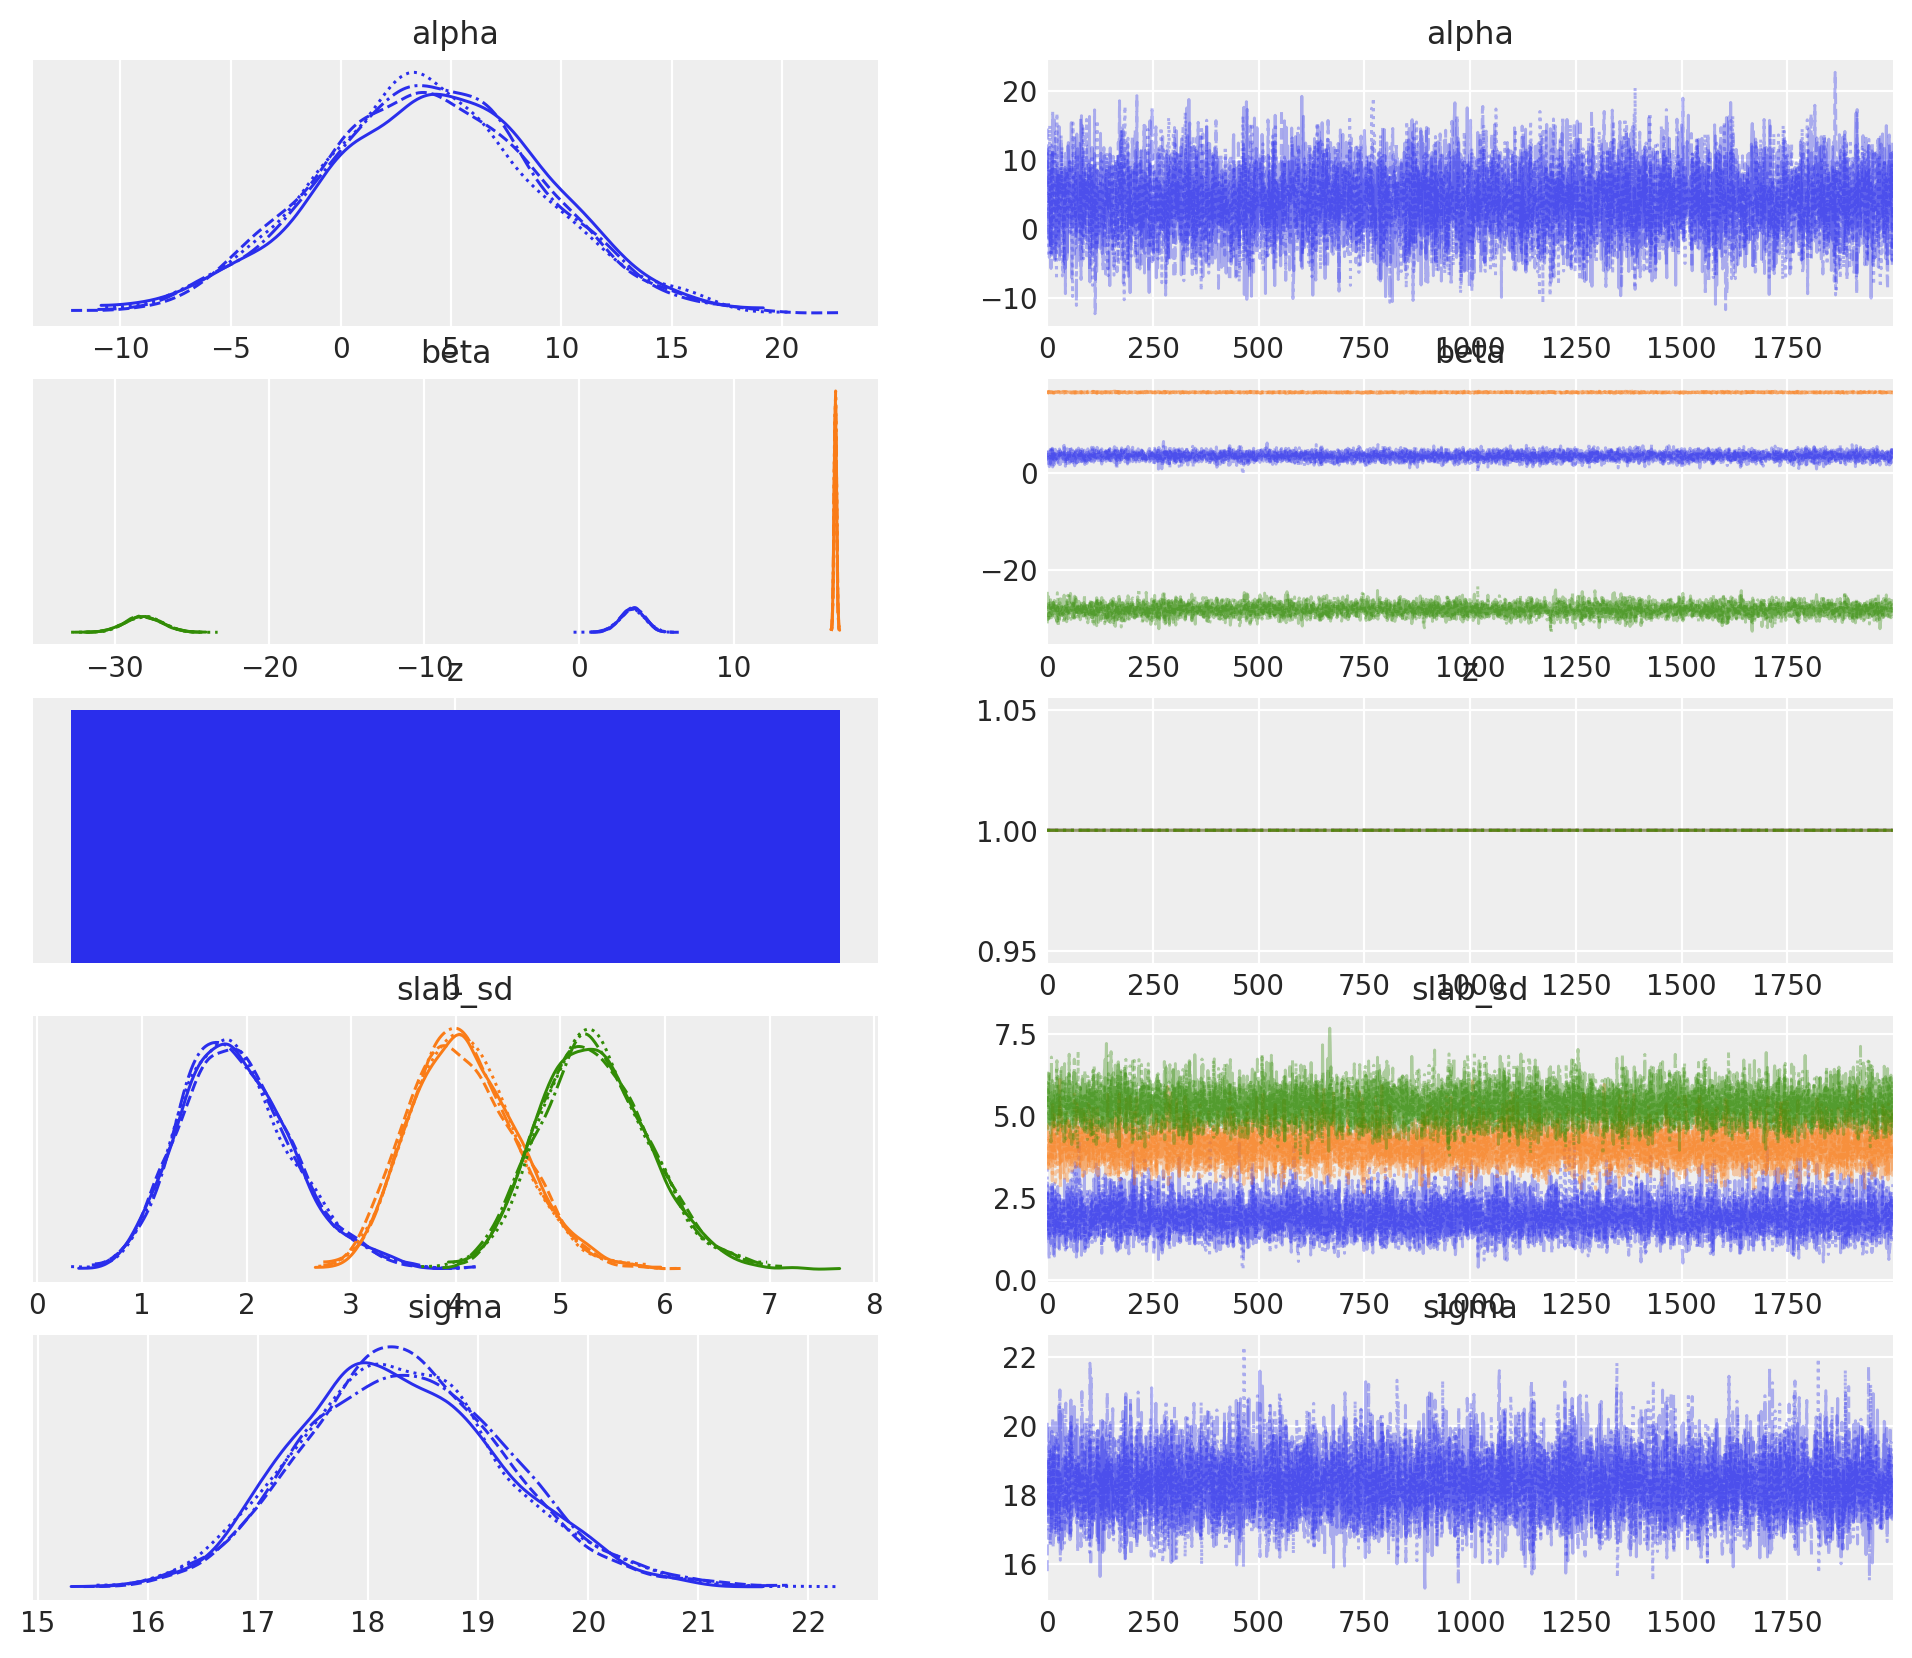

In [137]:
with pm.Model() as model_spike_slab:
    # Intercept
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    
    # Inclusion indicators
    # (Adjust p=0.5 if you want a different prior belief about how many vars are relevant)
    z = pm.Bernoulli("z", p=0.5, shape=k)
    
    # Slab standard deviations (assume half-normal prior)
    slab_sd = pm.HalfNormal("slab_sd", sigma=1, shape=k)
    
    # A tiny "spike" standard deviation
    spike_sd = 1e-6  # Very small, effectively zero

    # Coefficients
    # If z_j=1, stdev = slab_sd_j, if z_j=0, stdev = spike_sd
    # We can express that as z_j * slab_sd_j + (1 - z_j) * spike_sd
    beta_sd = z * slab_sd + (1 - z) * spike_sd
    beta = pm.Normal("beta", mu=0, sigma=beta_sd, shape=k)
    
    # Noise standard deviation
    sigma = pm.HalfCauchy("sigma", beta=1)

    # Expected value
    mu = alpha + pm.math.dot(X, beta)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # MCMC sampling
    trace_spike_slab = pm.sample(
        draws=2000, tune=1000, target_accept=0.9, random_seed=42
    )

# Summaries and diagnostics
az.summary(trace_spike_slab, var_names=["alpha", "beta", "z", "slab_sd", "sigma"])
az.plot_trace(trace_spike_slab, var_names=["alpha", "beta", "z", "slab_sd", "sigma"]);

### Compare the Results

Horseshoe Model Summary:
           mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     4.154   5.010  -5.593   13.213      0.058    0.057    7532.0   
beta[0]   4.194   0.770   2.793    5.645      0.009    0.009    7187.0   
beta[1]  16.641   0.077  16.503   16.791      0.001    0.001    4886.0   
beta[2] -29.676   1.138 -31.817  -27.614      0.016    0.013    4846.0   
tau      14.338  19.756   0.478   36.828      0.346    1.591    3287.0   
lam[0]    1.327   2.602   0.026    3.685      0.038    0.427    4970.0   
lam[1]    3.716   7.203   0.060   10.218      0.103    0.814    4168.0   
lam[2]    6.149  13.033   0.075   18.082      0.191    2.007    3817.0   
sigma    18.190   0.930  16.507   19.954      0.011    0.011    7448.0   

         ess_tail  r_hat  
alpha      5653.0    1.0  
beta[0]    5661.0    1.0  
beta[1]    4820.0    1.0  
beta[2]    4670.0    1.0  
tau        4571.0    1.0  
lam[0]     4855.0    1.0  
lam[1]     5042.0    1.0  
lam[2]     4683.0 

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


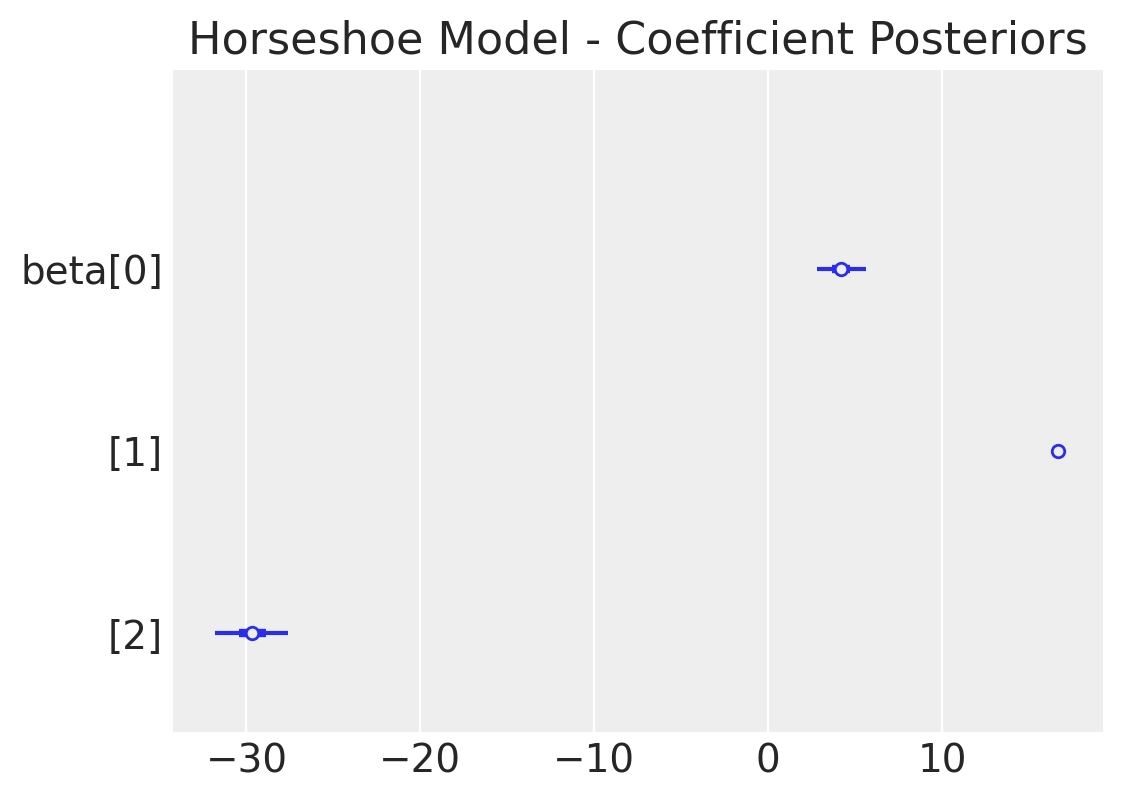

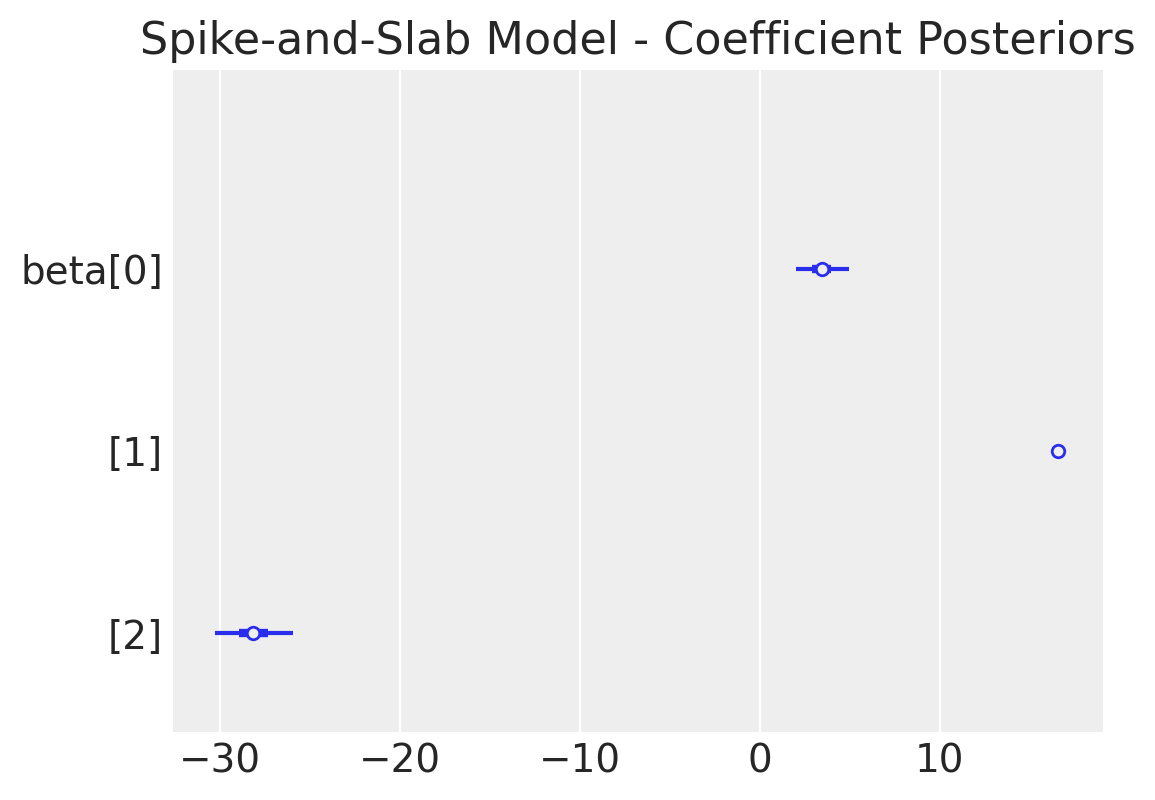

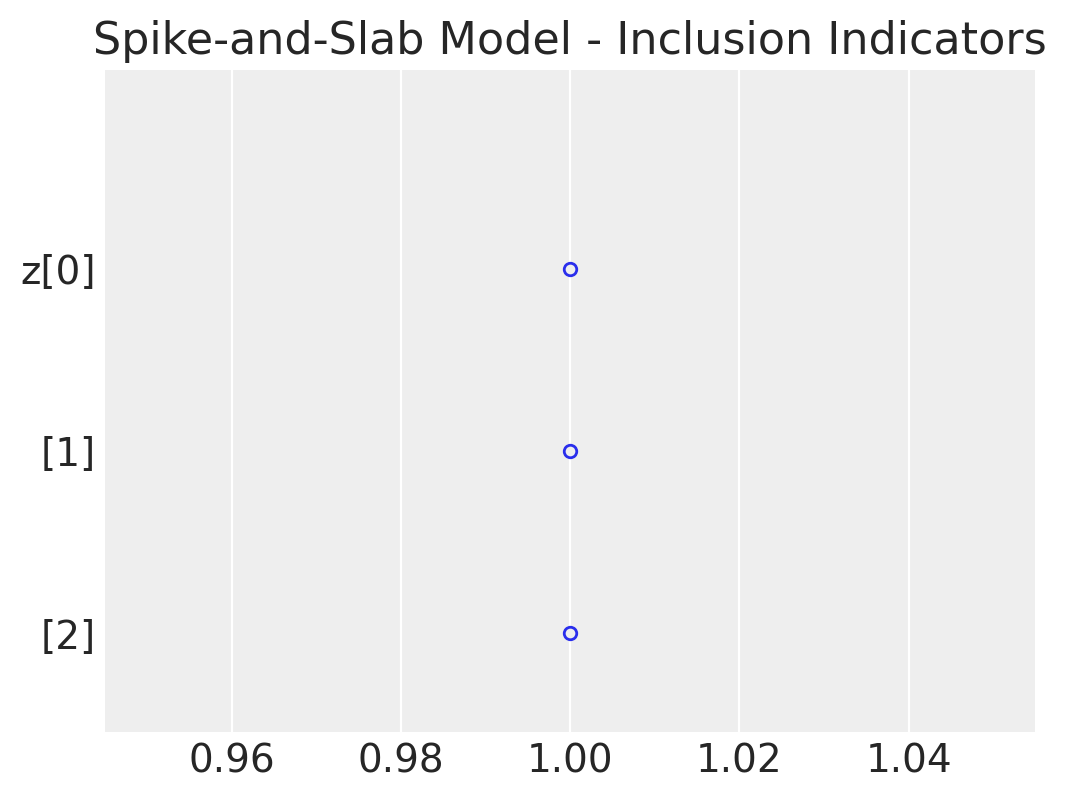

In [151]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ---------------------------
# Summaries of Posterior Inferences
# ---------------------------

# For Horseshoe model (assumed variables: alpha, beta, tau, lam, sigma)
hs_summary = az.summary(trace_horseshoe, var_names=["alpha", "beta", "tau", "lam", "sigma"])
print("Horseshoe Model Summary:")
print(hs_summary)

# For Spike-and-Slab model (assumed variables: alpha, beta, z, slab_sd, sigma)
ss_summary = az.summary(trace_spike_slab, var_names=["alpha", "beta", "z", "slab_sd", "sigma"])
print("\nSpike-and-Slab Model Summary:")
print(ss_summary)

# ---------------------------
# Visual Comparison of Coefficient Posteriors
# ---------------------------

# Plot the posterior distributions for the regression coefficients from the Horseshoe model
az.plot_forest(trace_horseshoe, var_names=["beta"], combined=True)
plt.title("Horseshoe Model - Coefficient Posteriors")
plt.show()

# Plot the posterior distributions for the regression coefficients from the Spike-and-Slab model
az.plot_forest(trace_spike_slab, var_names=["beta"], combined=True)
plt.title("Spike-and-Slab Model - Coefficient Posteriors")
plt.show()

# For the Spike-and-Slab model, you may also wish to see the inclusion indicators (z)
az.plot_forest(trace_spike_slab, var_names=["z"], combined=True)
plt.title("Spike-and-Slab Model - Inclusion Indicators")
plt.show()